In [42]:
# --- Modeling Setup ---

from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, roc_curve
)
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# --- Load data ---
df_metrics = pd.read_csv("../data/data_derivatives/features_within_subject.csv")
df_metrics = df_metrics[df_metrics["SedationLevel"] != 4].copy()  # drop recovery
features = [col for col in df_metrics if col.endswith("_ratio")]
target = "SedationLevel"
# features = [
#       'mean_degree',
#       'clustering', 
#       'path_length', 
#       'global_efficiency', 
#       'local_efficiency',
#       'modularity', 
#       'participation_coefficient', 
#       'small_worldness',
#       'mean_degree_delta',
#       'clustering_delta', 
#       'path_length_delta', 
#       'global_efficiency_delta',
#       'local_efficiency_delta', 
#       'modularity_delta',
#       'participation_coefficient_delta', 
#       'small_worldness_delta'
#    ]

X = df_metrics[features].copy()
y = df_metrics[target]
groups = df_metrics["Subject"]
gss = GroupShuffleSplit(test_size=0.2, n_splits=1, random_state=42)
train_idx, test_idx = next(gss.split(df_metrics, groups=groups))

X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

# Scaling 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [48]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95)  # retain 95% variance
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [49]:
rf = RandomForestClassifier(
    n_estimators=300,        # still enough trees for stability
    max_depth=8,             # limits overfitting
    min_samples_leaf=4,      # prevents very small terminal nodes
    max_features='sqrt',
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train_pca, y_train)



,n_estimators,300
,criterion,'gini'
,max_depth,8
,min_samples_split,2
,min_samples_leaf,4
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [50]:

print(f"Train accuracy: {rf.score(X_train_pca, y_train):.2f}")
print(f"Test accuracy: {rf.score(X_test_pca, y_test):.2f}")

Train accuracy: 1.00
Test accuracy: 0.50


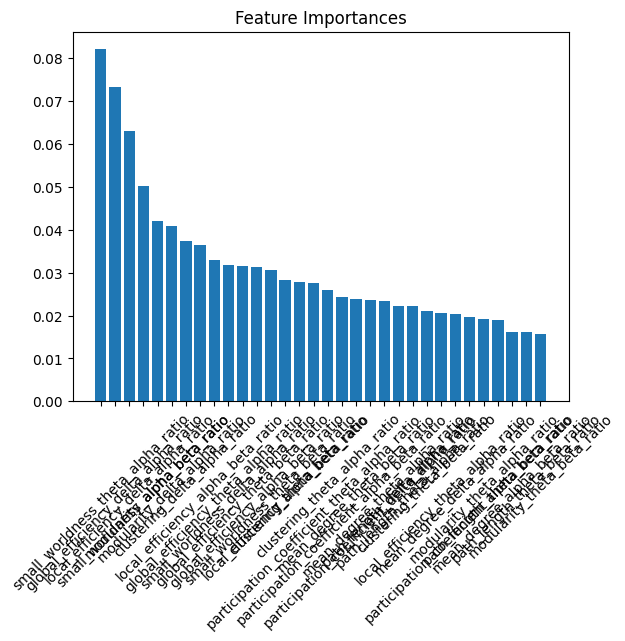

In [47]:
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
plt.bar(range(len(features)), importances[indices])
plt.xticks(range(len(features)), np.array(features)[indices], rotation=45)
plt.title("Feature Importances")
plt.show()

In [ ]:
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GroupKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler

# Group-aware CV
gkf = GroupKFold(n_splits=5)

# Define pipeline: scaling → PCA → RandomForest
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=0.95)),
    ("rf", RandomForestClassifier(random_state=42, n_jobs=-1))
])

# Parameter grid (you can also tune n_components if you want)
param_grid = {
    "rf__n_estimators": [200, 400, 600],
    "rf__max_depth": [3, 4, 5],
    "rf__min_samples_leaf": [3, 4, 5, 6],
    "rf__max_features": [0.4, 0.5, 0.6]
}

grid_search = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=gkf,
    scoring="accuracy",
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X, y, groups=groups)

print("Best parameters:", grid_search.best_params_)
print(f"Best cross-val accuracy: {grid_search.best_score_:.3f}")

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
[CV] END pca__n_components=0.9, rf__max_depth=4, rf__max_features=sqrt, rf__min_samples_leaf=2, rf__n_estimators=200; total time=   0.2s
[CV] END pca__n_components=0.9, rf__max_depth=4, rf__max_features=sqrt, rf__min_samples_leaf=2, rf__n_estimators=200; total time=   0.2s
[CV] END pca__n_components=0.9, rf__max_depth=4, rf__max_features=sqrt, rf__min_samples_leaf=2, rf__n_estimators=200; total time=   0.3s
[CV] END pca__n_components=0.9, rf__max_depth=4, rf__max_features=sqrt, rf__min_samples_leaf=2, rf__n_estimators=200; total time=   0.3s
[CV] END pca__n_components=0.9, rf__max_depth=4, rf__max_features=sqrt, rf__min_samples_leaf=2, rf__n_estimators=200; total time=   0.3s
[CV] END pca__n_components=0.9, rf__max_depth=4, rf__max_features=sqrt, rf__min_samples_leaf=2, rf__n_estimators=300; total time=   0.3s
[CV] END pca__n_components=0.9, rf__max_depth=4, rf__max_features=sqrt, rf__min_samples_leaf=2, rf__n_estimators=3